## Importar librerias

In [1]:
from __future__ import division
from pyomo.environ import *

from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

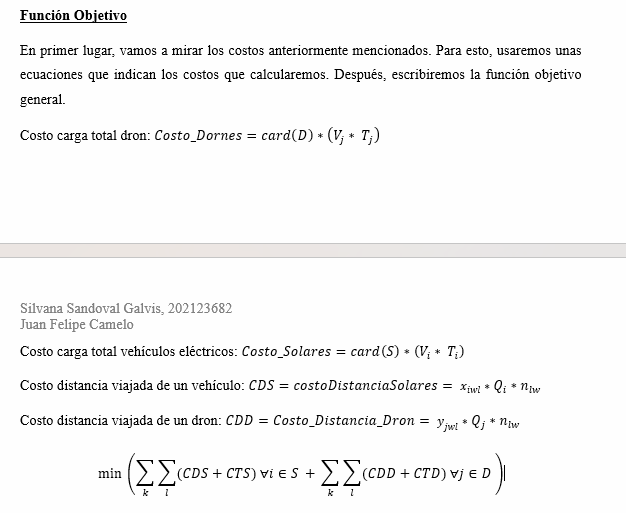

12 matrices de distancia de depots a cliente

In [ ]:

Model = ConcreteModel()

# Data de entrada
drones = 2
solar = 2


locs=RangeSet(0, drones)
travelers = RangeSet(1,solar)

#Conjunto
depots = pd.read_csv('data\multi_depots.csv')
clientes = pd.read_csv('data\clients.csv')





<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\c'
C:\Users\silva\AppData\Local\Temp\ipykernel_5096\1870091072.py:12: SyntaxWarning: invalid escape sequence '\m'
  depots = pd.read_csv('data\multi_depots.csv')
C:\Users\silva\AppData\Local\Temp\ipykernel_5096\1870091072.py:13: SyntaxWarning: invalid escape sequence '\c'
  clientes = pd.read_csv('data\clients.csv')


Construir las matrices.

In [3]:
matriz= []
long_depots = len(depots)
long_clientes = len(clientes)
for i in range(long_depots):
    distancias_depot = []
    longitud_depot = depots.iloc[i, 1]
    latitud_depot = depots.iloc[i, 2]
    for j in range(long_clientes):
        longitud_cliente = clientes.iloc[j, 1]
        latitud_cliente = clientes.iloc[j, 2]

        norma = np.sqrt((longitud_depot - longitud_cliente)**2 + (latitud_depot - latitud_cliente)**2)
        distancias_depot.append(norma)

    matriz.append(distancias_depot) 

In [ ]:
matriz


[[86.81323624670136,
  76.07397870371406,
  83.39695575862193,
  85.48027126018341,
  81.32175406923136,
  81.40471276946543,
  86.11063698511357,
  80.53818288125049,
  86.11063698511357,
  78.11364750846364,
  79.41285974168663,
  80.61367085725112,
  80.02437237033409,
  78.41708874977192,
  81.32175406923136,
  81.25101912415579,
  78.2117304547223,
  79.14798789370653,
  87.4216008338675,
  79.37088157043452,
  83.97946243408946,
  83.4898305543146,
  80.09099399820346,
  79.195350645129,
  84.48499446855253,
  82.49478360251014,
  79.11323790263988,
  81.32175406923136,
  81.85795969732965,
  75.15154057083305,
  76.33750888705113,
  85.11098235609093,
  80.73452486553593,
  84.39321485859352,
  78.57527558390981,
  83.4898305543146,
  83.18986417381439,
  79.62035823027946,
  75.64886983468611,
  82.60078024938744,
  81.11244898390179,
  84.70368021943668,
  81.146342840258,
  77.19830694437903,
  79.14798789370653,
  78.41708874977192,
  80.408735699027,
  86.3859923997815],
 [

In [6]:
len(matriz)

12

In [7]:
len(matriz[0])

48

In [9]:
matriz_clientes= []
long_clientes = len(clientes)
for i in range(long_clientes):
    distancias_cliente = []
    longitud_cliente_1 = clientes.iloc[i, 1]
    latitud_cliente_1 = clientes.iloc[i, 2]
    for j in range(long_clientes):
        longitud_cliente_2 = clientes.iloc[j, 1]
        latitud_cliente_2 = clientes.iloc[j, 2]

        norma = np.sqrt((longitud_cliente_1 - longitud_cliente_2)**2 + (latitud_cliente_1 - latitud_cliente_2)**2)
        distancias_cliente.append(norma)

    matriz_clientes.append(distancias_depot) 

In [ ]:
len(matriz_clientes)


48

In [11]:
len(matriz_clientes[0])

48

In [13]:
costos = pd.read_csv('data\data_vehiculos.csv')

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\silva\AppData\Local\Temp\ipykernel_5096\3630518346.py:1: SyntaxWarning: invalid escape sequence '\d'
  costos = pd.read_csv('data\data_vehiculos.csv')


In [14]:
costos.head()

,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/(gal or kWh)],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficency [kWh/km]
0,Gas Car,5000,500,30000,16000.00,0.1,NaN,10.0,NaN
1,Drone,500,500,3000,220.73,2.0,40.0,NaN,0.15
2,Solar EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15


In [ ]:
# df = pd.read_csv('MOS\Lab 2\proof_case_ext.csv')
# costos = df.to_dict()
# costos = {int(k): v for k, v in costos.items()}
# costosMatrix = df.values


# #Variable de decisión
# Model.x = Var(locs, locs, travelers, domain= Binary, initialize=0)

# #Variable Auxiliar
# Model.u = Var(locs, travelers,domain= NonNegativeReals)

# # Función objetivo
# Model.obj = Objective(expr = sum(Model.x[i,j,k]*costosMatrix[i,j] for i in locs for j in locs for k in travelers), sense=minimize)

# # Restricciones

# Model.lista1 = ConstraintList()
# Model.lista2 = ConstraintList()
# Model.lista5 = ConstraintList()
# for j in locs:
#     if j != 0:
#         Model.lista1.add(sum(Model.x[i,j,k] for k in travelers for i in locs if i!= j) == 1) # and i!=0
#         Model.lista2.add(sum(Model.x[j,i,k] for k in travelers for i in locs if i!= j) == 1) # and i!=0
#     else:
#         Model.lista5.add(sum(Model.x[i,j,k] for k in travelers for i in locs if i!= j) == sum(Model.x[j,i,k] for k in travelers for i in locs if i!= j))
        

# Model.lista3 = ConstraintList()
# for k in travelers:
#    for i in locs:
#        for j in locs:
#             if i != j and i != 0 and j != 0:
#                 Model.lista3.add(Model.u[i,k]-Model.u[j,k]+(localidades)*Model.x[i,j,k] <= (localidades - 1)) 

# Model.lista7 = ConstraintList()
# for k in travelers:
#     for j in locs:
#         Model.lista7.add(sum(Model.x[i,j,k] for i in locs if i!= j) == sum(Model.x[j,i,k]  for i in locs if i!= j))

# Model.lista4 = ConstraintList()
# for k in travelers:
#     Model.lista4.add(Model.u[0,k] == 1)

# Model.lista6 = ConstraintList()
# for k in travelers:
#    Model.lista6.add(sum(Model.x[0,j,k] for j in locs if j != 0) == 1)


# # Especificación del solver
# SolverFactory('glpk').solve(Model)

# Model.display()

# routes = []
# for k in travelers:
#     for i in locs:
#         for j in locs:
#             if i != j and Model.x[i,j,k].value == 1:
#                 routes.append((i, j))

# # Create a directed graph
# G = nx.DiGraph()

# # Add nodes (locations)
# G.add_nodes_from(locs)

# # Add edges (routes between locations)
# for route in routes:
#     G.add_edge(route[0], route[1], weight=costosMatrix[route[0], route[1]])

# # Set layout for visualization
# pos = nx.spring_layout(G)

# # Draw the network graph
# plt.figure(figsize=(10, 7))
# nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=14, font_color='black', font_weight='bold', arrows=True)

# # Draw the edge labels (costs)
# labels = {(i, j): f'{costosMatrix[i,j]:.2f}' for i, j in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# plt.title("Optimal Travel Routes Between Locations")
# plt.show()